<a href="https://colab.research.google.com/github/Dev2104/data-science/blob/main/AI_%26_ML_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report


# ----------------------------
# 0) Configuration
# ----------------------------
SEED = 42
EPOCHS = 12
BATCH_SIZE = 128
LEARNING_RATE = 1e-3

# EXACTLY 6 hidden layers:
HIDDEN_UNITS = (256, 256, 128, 128, 64, 64)

np.random.seed(SEED)
tf.random.set_seed(SEED)


In [2]:
# ----------------------------
# 1) Load MNIST dataset
# ----------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("MNIST Loaded")
print("Train images:", x_train.shape, "Train labels:", y_train.shape)
print("Test  images:", x_test.shape, "Test  labels:", y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MNIST Loaded
Train images: (60000, 28, 28) Train labels: (60000,)
Test  images: (10000, 28, 28) Test  labels: (10000,)


In [3]:
# ----------------------------
# 2) Preprocess data
#    - normalize to [0,1]
#    - flatten 28x28 -> 784
#    - one-hot encode labels for categorical crossentropy
# ----------------------------
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train_flat = x_train.reshape(-1, 28 * 28)  # (60000, 784)
x_test_flat = x_test.reshape(-1, 28 * 28)    # (10000, 784)

y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

In [4]:
# ----------------------------
# 3) Plot utilities (bifurcated display)
# ----------------------------
def show_plot():
    """
    Forces plots to appear one-by-one (bifurcated), avoiding "all at once" stacking.
    Works well in most environments.
    """
    plt.show(block=True)
    plt.pause(0.1)
    plt.close()


def plot_history(history, title_prefix: str):
    hist = history.history

    # Accuracy
    plt.figure()
    plt.plot(hist["accuracy"], label="Train Accuracy")
    plt.plot(hist["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Accuracy")
    plt.legend()
    show_plot()

    # Loss
    plt.figure()
    plt.plot(hist["loss"], label="Train Loss")
    plt.plot(hist["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Loss")
    plt.legend()
    show_plot()


def plot_confusion_matrix(cm: np.ndarray, title: str):
    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.tight_layout()
    show_plot()


def show_sample_predictions(x_flat, y_true, y_pred, title: str, n: int = 16):
    """
    Displays sample MNIST digit images with True vs Pred labels.
    x_flat must be (N, 784); reshaped to 28x28 for visualization.
    """
    n = int(n)
    n = max(1, min(n, len(x_flat)))

    idx = np.random.choice(len(x_flat), size=n, replace=False)

    cols = 4
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(10, 8))
    for i, j in enumerate(idx, start=1):
        img = x_flat[j].reshape(28, 28)
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap="gray")
        plt.title(f"T:{y_true[j]}  P:{y_pred[j]}")
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    show_plot()

In [5]:
# ----------------------------
# 4) Model builder: Input + 6 Hidden + Output(10 Softmax)
# ----------------------------
def build_model(hidden_activation: str) -> tf.keras.Model:
    if len(HIDDEN_UNITS) != 6:
        raise ValueError("Requirement violation: you must have exactly 6 hidden layers.")

    model = models.Sequential(name=f"MNIST_{hidden_activation.upper()}_6HL")
    model.add(layers.Input(shape=(784,), name="input_layer"))

    for i, units in enumerate(HIDDEN_UNITS, start=1):
        model.add(layers.Dense(units, activation=hidden_activation, name=f"hidden_{i}_{units}"))

    # Output layer: 10 classes (0-9) with Softmax probability distribution
    model.add(layers.Dense(10, activation="softmax", name="output_softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [6]:
# ----------------------------
# 5) Train & Evaluate function
# ----------------------------
def train_and_evaluate(hidden_activation: str, show_wrong_only: bool = False):
    model = build_model(hidden_activation)

    print("\n" + "=" * 80)
    print(f"Training model: {model.name}")
    model.summary()

    # Optional good-practice early stopping (doesn't save files; just improves training)
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=3,
            restore_best_weights=True
        )
    ]

    history = model.fit(
        x_train_flat, y_train_cat,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        callbacks=callbacks
    )

    test_loss, test_acc = model.evaluate(x_test_flat, y_test_cat, verbose=0)

    probs = model.predict(x_test_flat, verbose=0)
    y_pred = np.argmax(probs, axis=1)

    # Print results
    print("\n" + "-" * 80)
    print(f"{hidden_activation.upper()} RESULTS")
    print(f"Test Loss:     {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    # Show training curves
    plot_history(history, title_prefix=f"{hidden_activation.upper()} Hidden Layers")

    # Show confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, title=f"Confusion Matrix - {hidden_activation.upper()} Hidden Layers")

    # Show sample images (either random samples or wrong predictions)
    if show_wrong_only:
        wrong_idx = np.where(y_pred != y_test)[0]
        print(f"\nWrong predictions: {len(wrong_idx)} / {len(y_test)}")
        if len(wrong_idx) > 0:
            show_sample_predictions(
                x_flat=x_test_flat[wrong_idx],
                y_true=y_test[wrong_idx],
                y_pred=y_pred[wrong_idx],
                title=f"Wrong Predictions - {hidden_activation.upper()}",
                n=16
            )
        else:
            print("No wrong predictions found in the selected set (rare).")
    else:
        show_sample_predictions(
            x_flat=x_test_flat,
            y_true=y_test,
            y_pred=y_pred,
            title=f"Sample Predictions - {hidden_activation.upper()}",
            n=16
        )

    return test_loss, test_acc



Training model: MNIST_SIGMOID_6HL


Model: "MNIST_SIGMOID_6HL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1_256 (Dense)            │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2_256 (Dense)            │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3_128 (Dense)            │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4_128 (Dense)            │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_5_64 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_6_64 (Dense)             │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Dense)          │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,226 (1.26 MB)

 Trainable params: 329,226 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.1896 - loss: 2.0674 - val_accuracy: 0.5693 - val_loss: 1.1435
Epoch 2/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6493 - loss: 0.9622 - val_accuracy: 0.8032 - val_loss: 0.5428
Epoch 3/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8453 - loss: 0.4870 - val_accuracy: 0.9232 - val_loss: 0.2932
Epoch 4/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9194 - loss: 0.3121 - val_accuracy: 0.9485 - val_loss: 0.2052
Epoch 5/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9444 - loss: 0.2202 - val_accuracy: 0.9520 - val_loss: 0.1800
Epoch 6/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9570 - loss: 0.1738 - val_accuracy: 0.9525 - val_loss: 0.1749
Epoch 7/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9626 - loss: 0.1480 - val_accuracy: 0.9648 - val_loss: 0.1353
Epoch 8/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9687 - loss: 0.1233 - val_accu

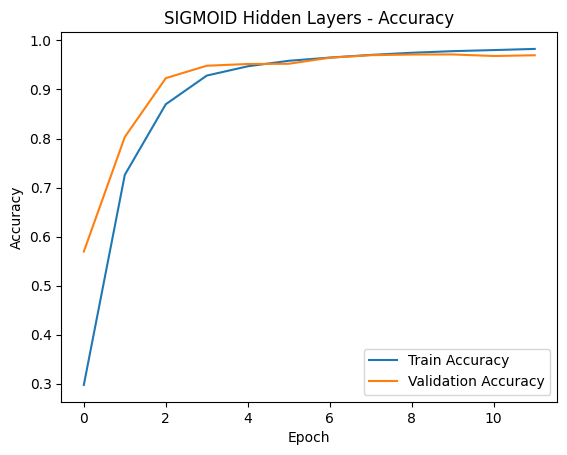

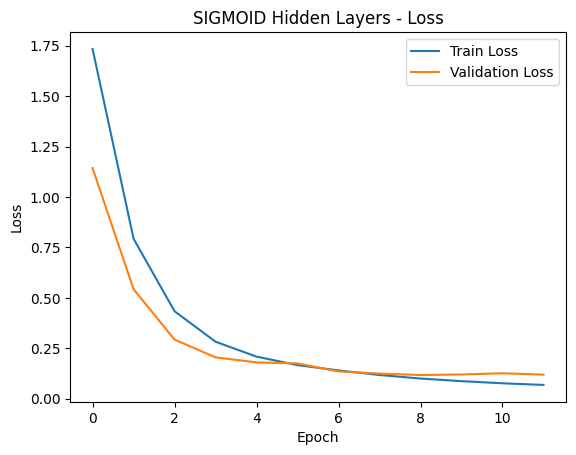

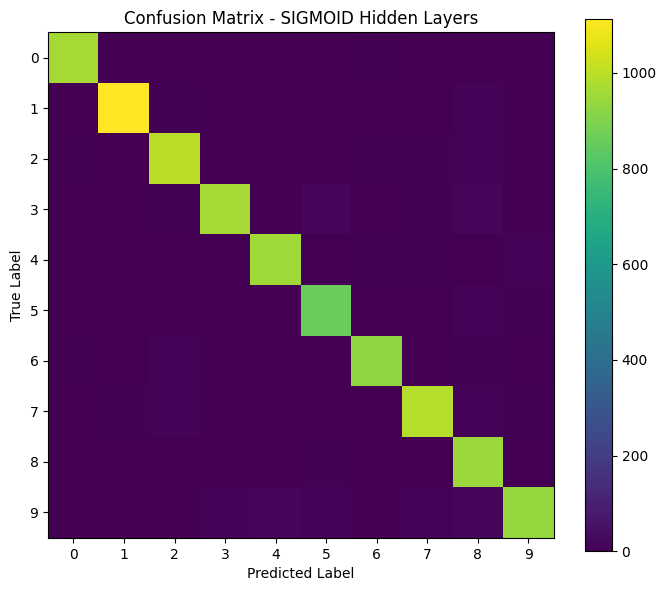

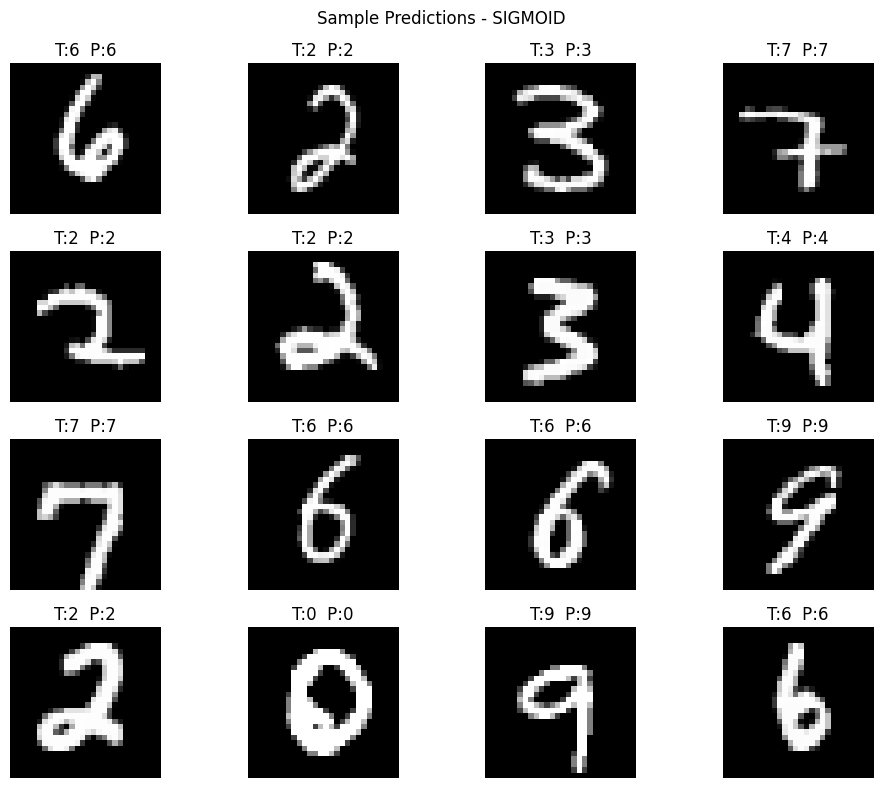


Training model: MNIST_TANH_6HL


Model: "MNIST_TANH_6HL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1_256 (Dense)            │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2_256 (Dense)            │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3_128 (Dense)            │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4_128 (Dense)            │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_5_64 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_6_64 (Dense)             │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Dense)          │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,226 (1.26 MB)

 Trainable params: 329,226 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8575 - loss: 0.5053 - val_accuracy: 0.9603 - val_loss: 0.1293
Epoch 2/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9556 - loss: 0.1502 - val_accuracy: 0.9680 - val_loss: 0.1059
Epoch 3/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9683 - loss: 0.1052 - val_accuracy: 0.9702 - val_loss: 0.1002
Epoch 4/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9750 - loss: 0.0780 - val_accuracy: 0.9738 - val_loss: 0.0864
Epoch 5/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9814 - loss: 0.0596 - val_accuracy: 0.9707 - val_loss: 0.1028
Epoch 6/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9835 - loss: 0.0510 - val_accuracy: 0.9725 - val_loss: 0.0979
Epoch 7/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9867 - loss: 0.0414 - val_accuracy: 0.9690 - val_loss: 0.1112

--------------------------------------------------------------------------------
TANH RESULTS
T

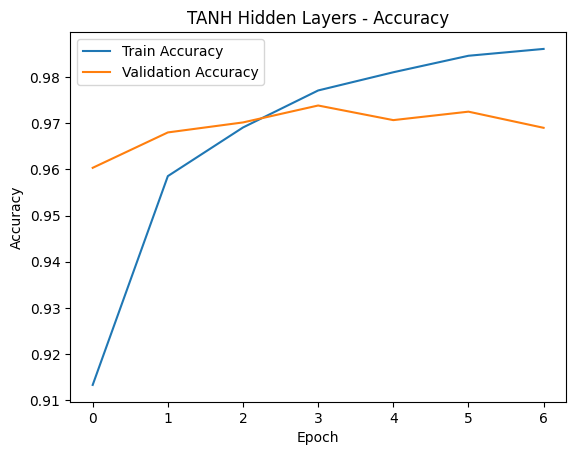

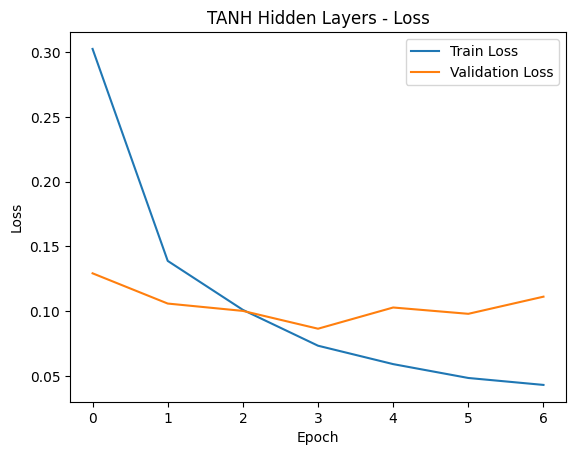

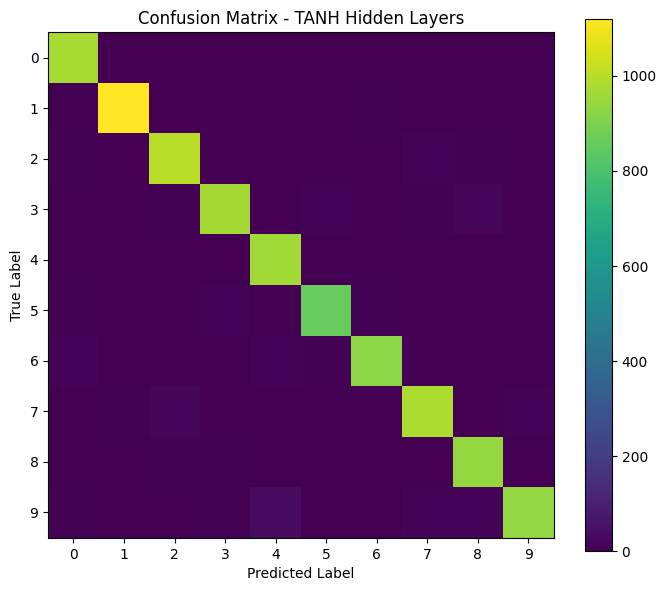

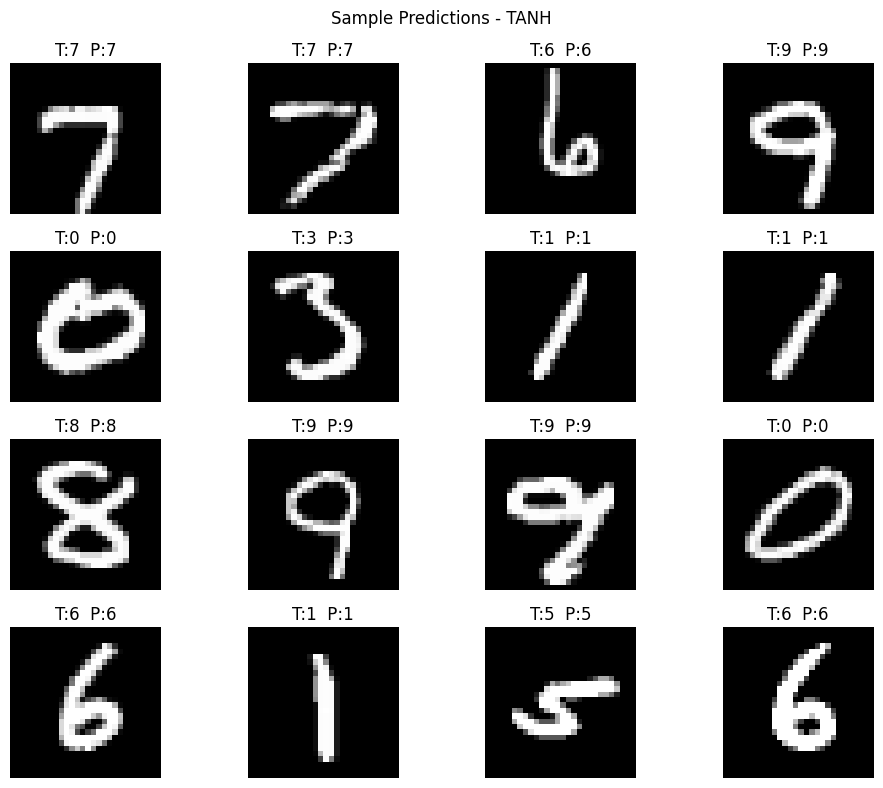


FINAL COMPARISON (Test Set)
Sigmoid -> Loss: 0.1362, Accuracy: 0.9653
Tanh    -> Loss: 0.1085, Accuracy: 0.9677


In [7]:
# ----------------------------
# 6) Run both experiments: Sigmoid vs Tanh
# ----------------------------
sig_loss, sig_acc = train_and_evaluate("sigmoid", show_wrong_only=False)
tanh_loss, tanh_acc = train_and_evaluate("tanh", show_wrong_only=False)

print("\n" + "=" * 80)
print("FINAL COMPARISON (Test Set)")
print(f"Sigmoid -> Loss: {sig_loss:.4f}, Accuracy: {sig_acc:.4f}")
print(f"Tanh    -> Loss: {tanh_loss:.4f}, Accuracy: {tanh_acc:.4f}")